In [1]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)






/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

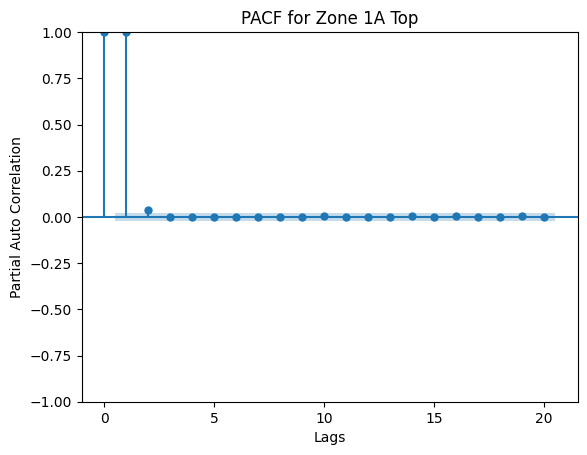

<Figure size 1000x500 with 0 Axes>

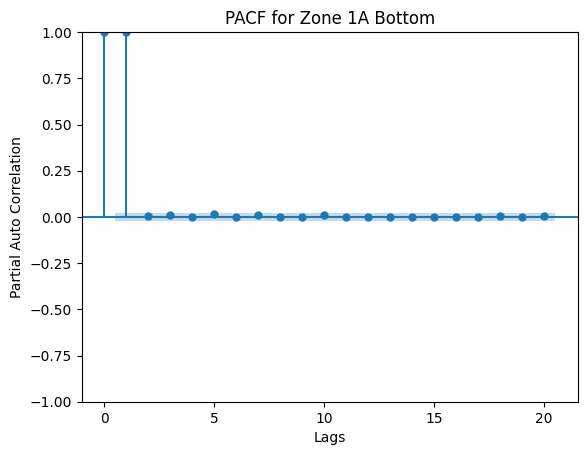

<Figure size 1000x500 with 0 Axes>

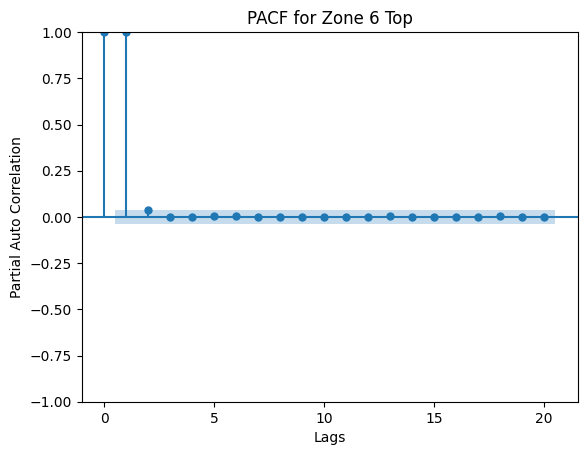

<Figure size 1000x500 with 0 Axes>

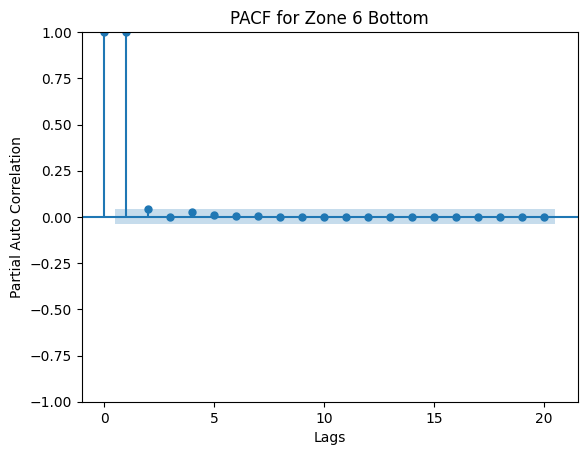

<Figure size 1000x500 with 0 Axes>

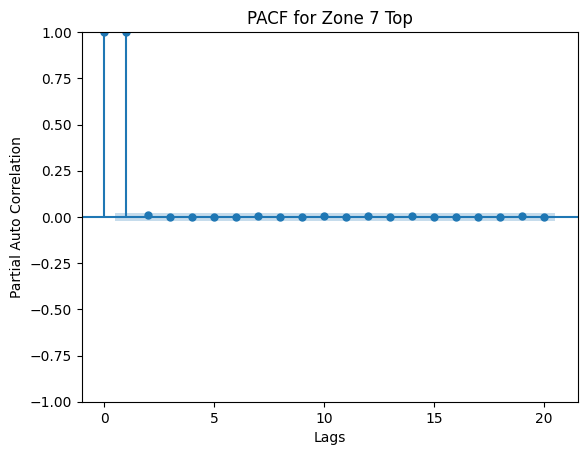

<Figure size 1000x500 with 0 Axes>

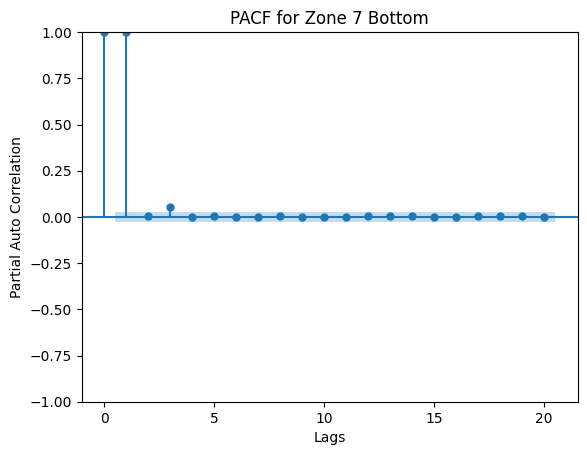